In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Redes Generativas Adversariais (GANs)

As **Redes Generativas Adversariais (GANs - *Generative Adversarial Networks*)** são um framework de aprendizado de máquina proposto por Ian Goodfellow em 2014. Elas consistem em dois modelos neurais em competição:

1. **Gerador (*Generator*)**  
   - Gera dados sintéticos a partir de uma distribuição de entrada, no nosso caso, são ruídos aleatórios.  
   - Objetivo: "enganar" o discriminador, produzindo amostras indistinguíveis de dados reais.

2. **Discriminador (*Discriminator*)**  
   - Classifica se uma amostra é real ou falsa, ou seja, classifica se a imagem vem do conjunto de dados original ou se foi produzida pelo gerador.  
   - Objetivo: identificar corretamente as amostras falsas.  

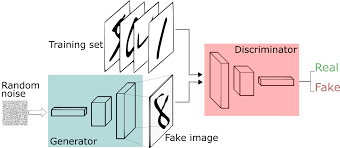

## Funcionamento  
Os dois modelos são treinados simultaneamente em um **jogo minimax**:  
- O gerador melhora gradativamente sua capacidade de gerar dados realistas.  
- O discriminador aprimora sua habilidade de detectar falsificações.  

Em uma situação perfeita, o gerador produz dados de alta qualidade, e o discriminador não consegue distinguir entre real e sintético, então a taxa de acerto fica em 50%.  

## Aplicações Comuns  
- Geração de imagens realistas
- Super-resolução de imagens
- Tradução de estilos
- Preenchimento de dados faltantes

## Desafios  
- **Modo colapso**: Gerador produz pouca variedade de saídas.  
- **Dificuldade de treino**: Requer balanceamento entre os modelos.  

As GANs revolucionaram a geração de dados sintéticos.  

## Implementado o modelo

### Configuração de ambiente

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
image_channels = 100
batch_size = 16
epochs = 50
learning_rate = 0.0002

### Importando as imagens

In [12]:
# tranformações que serão aplicadas a todos os dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
# baixando os dados (dataset de numeros escritos a mao)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Definindo o modelo

In [14]:
# Modelo Gerador
class Generator(nn.Module):
    def __init__(self, image_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_channels, 256),
            nn.ReLU(0.2),
            nn.Linear(256, 512),
            nn.ReLU(0.2),
            nn.Linear(512, 1024),
            nn.ReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Modelo Discrimidador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(0.2),
            nn.Linear(512, 256),
            nn.ReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.size(0), -1)
        x = self.model(img)
        return x

In [15]:
print(device)

cuda


In [16]:
# instanciando os modelos
generator = Generator(image_channels).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### Treinando

In [17]:
# definindo a funcao de loss e os otimizadores
adversarial_loss = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [18]:
history_loss_g = []
history_loss_d = []
for epoch in range(epochs):
    loss_g = 0
    loss_d = 0
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        optimizer_d.zero_grad()

        ### treinando o discriminador

        # treinando em imagens verdadeiras
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        real_output = discriminator(real_imgs)
        real_loss = adversarial_loss(real_output, real_labels)
        real_loss.backward()
        # optimizer_d.step()

        # treinando em imagens falsas
        noise = torch.randn(real_imgs.size(0), image_channels).to(device)
        fake_imgs = generator(noise) # gerando imagens falsas
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)
        fake_output = discriminator(fake_imgs.detach())
        fake_loss = adversarial_loss(fake_output, fake_labels)
        fake_loss.backward()
        optimizer_d.step()

        loss_d += real_loss + fake_loss

        ### treinando o gerador
        optimizer_g.zero_grad()
        fake_imgs = generator(noise)
        output_g = discriminator(fake_imgs)
        loss = adversarial_loss(output_g, real_labels)
        loss.backward()
        optimizer_g.step()
        loss_g += loss

    # printando metricas
    loss_g /= i
    loss_d /= i
    history_loss_d.append(loss_d)
    history_loss_g.append(loss_g)
    print(f"[Epoch {epoch}/{epochs}]")
    print(f"[D loss: {loss_d.item():.4f}] [G loss: {loss_g.item():.4f}]")

    # salvando imagens geradas
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            sample_noise = torch.randn(16, image_channels).to(device)
            gen_img = generator(sample_noise).cpu().numpy()
            gen_img = gen_img.reshape(-1, 28, 28)

            fig, axs = plt.subplots(4, 4, figsize=(4, 4))
            cnt = 0
            for i in range(4):
                for j in range(4):
                    axs[i,j].imshow(gen_img[cnt], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
            plt.savefig(f"gan_images/epoch_{epoch}.png")
            plt.close()

torch.save(generator.state_dict(), './models/generator.pth')
torch.save(discriminator.state_dict(), './models/discriminator.pth')

[Epoch 0/50]
[D loss: 0.6843] [G loss: 3.0392]
[Epoch 1/50]
[D loss: 0.6481] [G loss: 2.7660]
[Epoch 2/50]
[D loss: 0.6494] [G loss: 2.4121]
[Epoch 3/50]
[D loss: 0.5865] [G loss: 2.7791]
[Epoch 4/50]
[D loss: 0.5913] [G loss: 2.5136]
[Epoch 5/50]
[D loss: 0.6719] [G loss: 2.1762]
[Epoch 6/50]
[D loss: 0.7838] [G loss: 1.8695]
[Epoch 7/50]
[D loss: 0.8313] [G loss: 1.7270]
[Epoch 8/50]
[D loss: 0.9088] [G loss: 1.5494]
[Epoch 9/50]
[D loss: 0.9576] [G loss: 1.4409]
[Epoch 10/50]
[D loss: 1.0194] [G loss: 1.3293]
[Epoch 11/50]
[D loss: 1.0496] [G loss: 1.2702]
[Epoch 12/50]
[D loss: 1.0744] [G loss: 1.2202]
[Epoch 13/50]
[D loss: 1.1000] [G loss: 1.1667]
[Epoch 14/50]
[D loss: 1.1287] [G loss: 1.1237]
[Epoch 15/50]
[D loss: 1.1489] [G loss: 1.0906]
[Epoch 16/50]
[D loss: 1.1499] [G loss: 1.0835]
[Epoch 17/50]
[D loss: 1.1529] [G loss: 1.0786]
[Epoch 18/50]
[D loss: 1.1689] [G loss: 1.0515]
[Epoch 19/50]
[D loss: 1.1732] [G loss: 1.0413]
[Epoch 20/50]
[D loss: 1.1878] [G loss: 1.0251]
[E

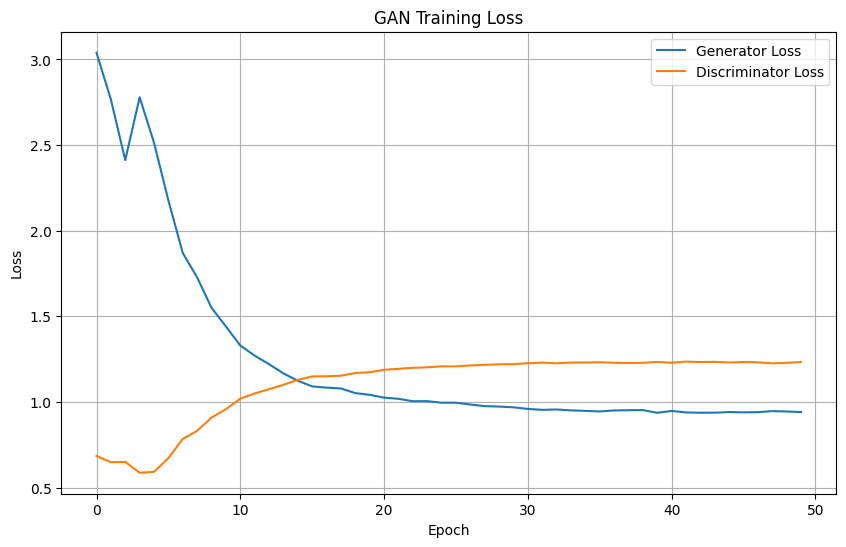

In [26]:
history_loss_d = [i.detach().cpu().numpy() for i in history_loss_d]
history_loss_g = [i.detach().cpu().numpy() for i in history_loss_g]

# plotando a loss de treinamento
plt.figure(figsize=(10, 6))
plt.plot(history_loss_g, label='Generator Loss')
plt.plot(history_loss_d, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid(True)
plt.show()

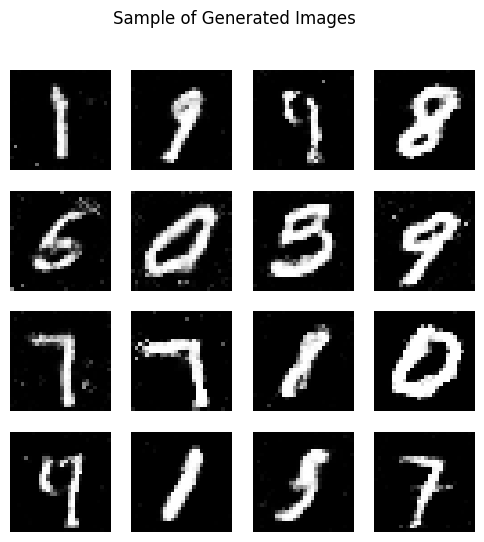

In [27]:
sample_noise = torch.randn(16, image_channels).to(device)
generator.eval()  # Colocar o gerador em modo de avaliação
with torch.no_grad():
    generated_images = generator(sample_noise).cpu().numpy()

# Remodelar as imagens geradas para 28x28
generated_images = generated_images.reshape(-1, 28, 28)

# Plotar as imagens
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.suptitle('Sample of Generated Images')
plt.show()